<a href="https://colab.research.google.com/github/melkatewabe10/Machine-learning_LST-Estimation-/blob/main/NDWI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Tewabe Melkamu

Date: 3/13/2025

NDWI_Data Collection

In [14]:
import ee
import folium
import matplotlib.pyplot as plt
import geemap
import math
# Authenticate to Earth Engine. This will open a browser window.
ee.Authenticate()

# Initialize the Earth Engine API.
ee.Initialize(project='ee-mftewabe')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# -------------------------------------------------------------------
# 1. Define the study region (Taiwan)
# -------------------------------------------------------------------
gaul = ee.FeatureCollection("FAO/GAUL/2015/level0")
taiwan = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Taiwan'))

# -------------------------------------------------------------------
# 2. Load ESA WorldCover and create a mask
# # -------------------------------------------------------------------
# worldcover = ee.ImageCollection("ESA/WorldCover/v200").first().clip(taiwan)
# mask = worldcover.neq(50).And(worldcover.neq(80))  # Remove built-up and water

# -------------------------------------------------------------------
# 3. Define cloud masking and NDWI computation functions.
# -------------------------------------------------------------------
def maskClouds(image):
    qa = image.select('StateQA')
    cloudBitMask = 1 << 10  # Bit 10 indicates clouds
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0)
    return image.updateMask(cloudMask)

def compute_ndwi(image):
    nir = image.select('sur_refl_b02').multiply(0.0001)  # Convert scaled reflectance
    swir = image.select('sur_refl_b07').multiply(0.0001)
    ndwi = nir.subtract(swir).divide(nir.add(swir)).rename('NDWI')
    return image.addBands(ndwi)

# -------------------------------------------------------------------
# 4. Define Seasons
# -------------------------------------------------------------------
seasons = {
    "Spring": ('03-01', '05-31'),
    "Summer": ('06-01', '08-31'),
    "Autumn": ('09-01', '11-30'),
    "Winter": ('12-01', '02-28')  # Winter spans two years
}

# -------------------------------------------------------------------
# 5. Loop through each year and export seasonal NDWI
# -------------------------------------------------------------------
for year in range(2002, 2025):
    print(f"Processing year: {year}")

    for season, (start, end) in seasons.items():
        print(f"  Processing {season} of {year}")

        if season == "Winter":
            start_date = ee.Date(f"{year}-12-01")
            end_date = ee.Date(f"{year + 1}-02-28")  # Winter spans two years
        else:
            start_date = ee.Date(f"{year}-{start}")
            end_date = ee.Date(f"{year}-{end}")

        # Load MODIS Surface Reflectance data
        collection = (ee.ImageCollection('MODIS/061/MYD09A1')
                      .filterDate(start_date, end_date)
                      .filterBounds(taiwan)

        )
        # Compute seasonal mean NDWI
        collection= collection.map(maskClouds).map(compute_ndwi)

        # Compute seasonal mean NDWI
        ndwi_mean = ndwi_mean.updateMask(ndwi_mean.gte(-0.5).And(ndwi_mean.lte(1)))


        # # Apply land mask
        # ndwi_masked = ndwi_mean.updateMask(mask)

        # Export to Google Drive
        task = ee.batch.Export.image.toDrive(
            image=ndwi_mean,
            description=f'NDWI_{year}_{season}',
            folder='NDWI',
            fileNamePrefix=f'NDWI_{year}_{season}',
            region=taiwan.geometry().bounds().getInfo()['coordinates'],
            scale=1000,  # MODIS resolution (~1 km)
            crs='EPSG:32651',
            maxPixels=1e13
        )

        task.start()
        print(f"Export task for {year} - {season} started. ")


Processing year: 2002
  Processing Spring of 2002
Export task for 2002 - Spring started. 
  Processing Summer of 2002
Export task for 2002 - Summer started. 
  Processing Autumn of 2002
Export task for 2002 - Autumn started. 
  Processing Winter of 2002
Export task for 2002 - Winter started. 
Processing year: 2003
  Processing Spring of 2003
Export task for 2003 - Spring started. 
  Processing Summer of 2003
Export task for 2003 - Summer started. 
  Processing Autumn of 2003
Export task for 2003 - Autumn started. 
  Processing Winter of 2003
Export task for 2003 - Winter started. 
Processing year: 2004
  Processing Spring of 2004
Export task for 2004 - Spring started. 
  Processing Summer of 2004
Export task for 2004 - Summer started. 
  Processing Autumn of 2004
Export task for 2004 - Autumn started. 
  Processing Winter of 2004
Export task for 2004 - Winter started. 
Processing year: 2005
  Processing Spring of 2005
Export task for 2005 - Spring started. 
  Processing Summer of 2005


In [6]:
# -------------------------------------------------------------------
# 1. Define the study region (Taiwan)
# -------------------------------------------------------------------
# Using the FAO GAUL 2015 dataset.
gaul = ee.FeatureCollection("FAO/GAUL/2015/level0")
taiwan = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Taiwan'))

# -------------------------------------------------------------------
# 2. Load ESA WorldCover and create a mask
# -------------------------------------------------------------------
# Load the first image from ESA WorldCover and clip it to Taiwan.
worldcover = ee.ImageCollection("ESA/WorldCover/v200").first().clip(taiwan)
# Class definitions from ESA WorldCover:
# 50 = Built-up, 80 = Permanent water bodies.
# We remove both built-up and permanent water by keeping pixels that are not 50 and not 80.
mask = worldcover.neq(50).And(worldcover.neq(80))

# -------------------------------------------------------------------
# 3. Define cloud masking and NDWI computation functions.
# -------------------------------------------------------------------
def maskClouds(image):
    # Select the quality band that contains cloud information.
    qa = image.select('StateQA')
    # Assume that bit 10 indicates clouds. (1 << 10) creates a bitmask with bit 10 set.
    cloudBitMask = 1 << 10
    # Use a bitwise AND to check whether the cloud bit is set.
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0)
    # Update the image mask so that cloudy pixels are removed.
    return image.updateMask(cloudMask)

def compute_ndwi(image):
    # Convert scaled surface reflectance to true reflectance.
    nir = image.select('sur_refl_b02').multiply(0.0001)
    swir = image.select('sur_refl_b07').multiply(0.0001)
    # Compute NDWI = (NIR - SWIR) / (NIR + SWIR)
    ndwi = nir.subtract(swir).divide(nir.add(swir)).rename('NDWI')
    return image.addBands(ndwi)

# -------------------------------------------------------------------
# 4. Loop through each year from 2005 to 2025 and export the yearly mean NDWI
# -------------------------------------------------------------------
for year in range(2000, 2003):
    print(f"Processing year: {year}")

    # Define the date range for the year.
    start_date = ee.Date(f'{year}-01-01')
    end_date = ee.Date(f'{year}-12-31')

    # Load the MODIS/061/MYD09A1 image collection for the given year and filter to Taiwan.
    collection = (ee.ImageCollection('MODIS/061/MYD09A1')
                  .filterDate(start_date, end_date)
                  .filterBounds(taiwan))

    # Apply cloud masking and compute NDWI for each image.
    collection = collection.map(maskClouds).map(compute_ndwi)

    # Compute the mean NDWI for the year and clip to Taiwan.
    ndwi_mean = collection.select('NDWI').mean().clip(taiwan)

    # Apply the ESA WorldCover mask.
    ndwi_masked = ndwi_mean.updateMask(mask)

    # Define and start the export task.
    task = ee.batch.Export.image.toDrive(
        image=ndwi_mean,
        description=f'NDWI_{year}',
        folder='NDWI_F',  # Update to your desired Google Drive folder.
        fileNamePrefix=f'NDWI_{year}',
        region=taiwan.geometry().bounds().getInfo()['coordinates'],
        scale=1000,  # Typical resolution for MODIS surface reflectance products.
        crs='EPSG:32651',
        maxPixels=1e13
    )
    task.start()
    print(f"Export task for {year} started. Please check your GEE tasks and Google Drive.")

# -------------------------------------------------------------------
# (Optional) Create an interactive map to visualize the final NDWI image.
# -------------------------------------------------------------------
# Uncomment the lines below to display an interactive map.
# Map = geemap.Map(center=[23.5, 121], zoom=7)
# Map.addLayer(ndwi_masked, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDWI Masked')
# Map.addLayer(taiwan, {}, 'Taiwan Boundary')
# Map.addLayerControl()  # Enable layer control
# Map


Processing year: 2000
Export task for 2000 started. Please check your GEE tasks and Google Drive.
Processing year: 2001
Export task for 2001 started. Please check your GEE tasks and Google Drive.
Processing year: 2002
Export task for 2002 started. Please check your GEE tasks and Google Drive.


In [ ]:
!pip install rasterio

Metadata:
driver: GTiff
dtype: float64
nodata: None
width: 282
height: 382
count: 1
crs: EPSG:32651
transform: | 1000.00, 0.00, 118000.00|
| 0.00,-1000.00, 2804000.00|
| 0.00, 0.00, 1.00|


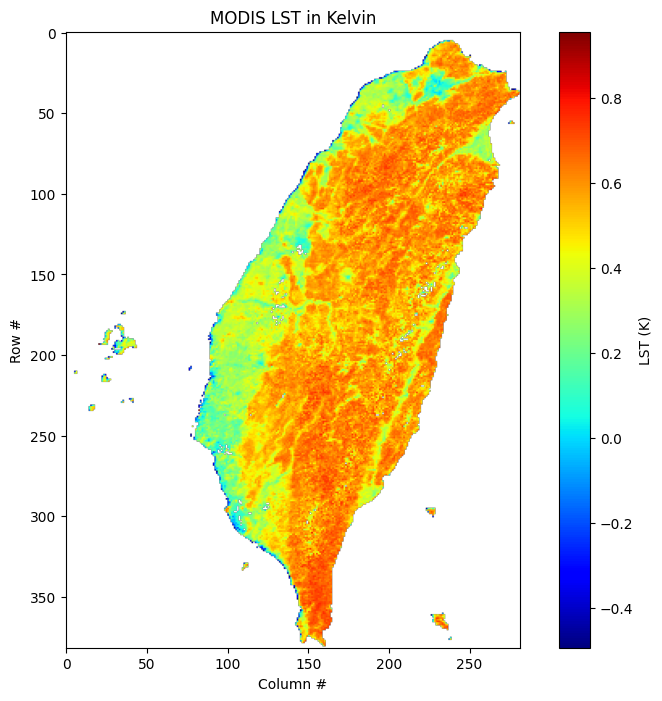

In [16]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to the downloaded GeoTIFF file.
filename = '/content/drive/MyDrive/NDWI/NDWI_2021_Autumn.tif'

# Open the file with rasterio
with rasterio.open(filename) as src:
    # Read the first band (assuming the LST is stored in a single band)
    lst_data = src.read(1)
    # Get metadata information
    meta = src.meta
    print("Metadata:")
    for key, value in meta.items():
        print(f"{key}: {value}")

# Mask no-data values (if present)
lst_masked = np.ma.masked_where(lst_data == src.nodata, lst_data)

# Plot the LST image using matplotlib
plt.figure(figsize=(10, 8))
cmap = plt.cm.jet  # choose a colormap
img = plt.imshow(lst_masked, cmap=cmap)
plt.colorbar(img, label='LST (K)')
plt.title('MODIS LST in Kelvin')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

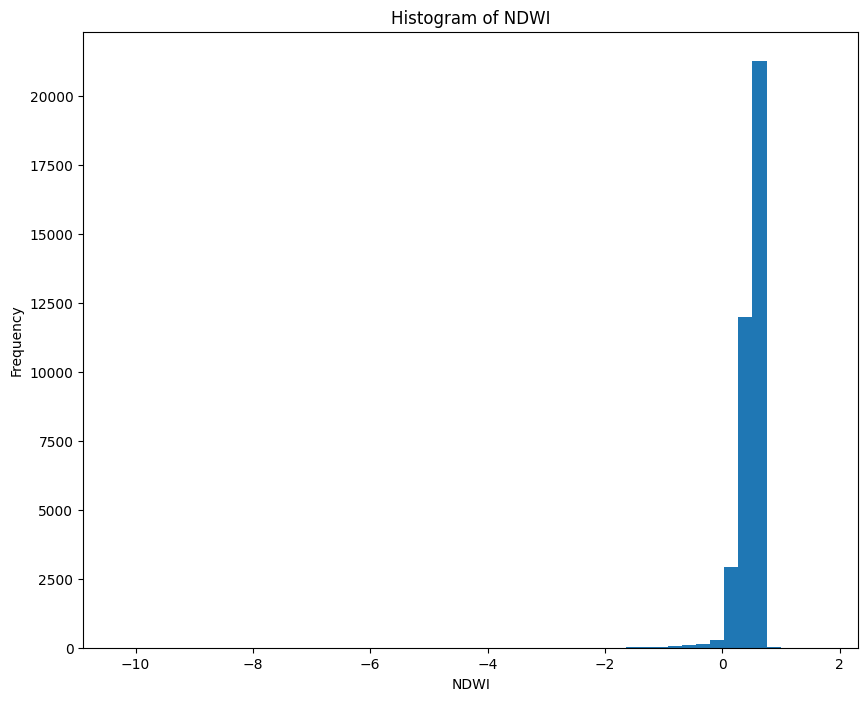

In [10]:
# prompt: Histogram

import matplotlib.pyplot as plt
# Assuming lst_masked is defined as in the provided code.
plt.figure(figsize=(10, 8))
plt.hist(lst_masked.compressed(), bins=50) # Use compressed() to exclude masked values
plt.xlabel('NDWI')
plt.ylabel('Frequency')
plt.title('Histogram of NDWI')
plt.show()
